In [51]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import powerlaw


In [72]:
# Hoshen-Kopelman Clustering algorithm
#https://en.wikipedia.org/wiki/Hoshen–Kopelman_algorithm

    Cluster_size  Cluster_count  cell_type
0            1.0          764.0        1.0
1            2.0          234.0        1.0
2            3.0          124.0        1.0
3            4.0           57.0        1.0
4            5.0           38.0        1.0
5            6.0           31.0        1.0
6            7.0           11.0        1.0
7            8.0            7.0        1.0
8            9.0            6.0        1.0
9           10.0            4.0        1.0
10          12.0            3.0        1.0
11          13.0            3.0        1.0
12          14.0            2.0        1.0
13          21.0            1.0        1.0
0            1.0          813.0        2.0
1            2.0          228.0        2.0
2            3.0          100.0        2.0
3            4.0           60.0        2.0
4            5.0           44.0        2.0
5            6.0           20.0        2.0
6            7.0           17.0        2.0
7            8.0            7.0        2.0
8          

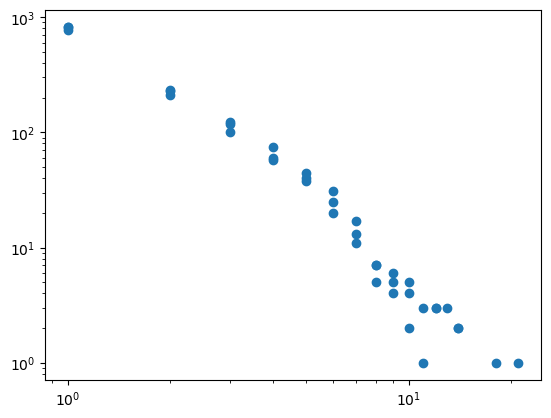

In [50]:
def clustering(m, rtype):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied 1 and unoccupied 0"""
    assert type(rtype) == int
    assert m.shape[0] == m.shape[1]
    
    dim = m.shape[0]
    largest_label = 0;
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == rtype:
                if above != rtype and left != rtype: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == rtype and left != rtype: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above != rtype and left == rtype: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == rtype and left == rtype: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)             
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same.
    """
    if label[x-1,y] == label[x,y-1]: # If labels are the same, then set x,y as same label
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

def run_clustering(m):
    """
    Runs the clustering algorithm for each of the cell types, returns a pandas dataframe with the columns cluster size, count, id.
    INPUT: the matrix with the different IDs in the cells. 
    """
    clusters = pd.DataFrame()
    # Run each of the cluster types in a loop
    for i in np.unique(m)[1:]: # not the zeros
        cluster_ids = clustering(m, int(i))
        cluster_size = np.unique(cluster_ids, return_counts=True) # count size of clusters in matrix of cell types
        size, count = np.unique(cluster_size[1][1:], return_counts=True) # select only the cells that contain something (first element is empty)
        # f
        clusters = pd.concat([clusters, pd.DataFrame([size, count, i * np.ones(len(count))]).T], axis = 0)
        
    clusters.columns = ['Cluster_size','Cluster_count','cell_type']
    return clusters

m = np.random.randint(0,4, (100,100), dtype=int)

x = run_clustering(m)
print(x)
# Just testing the log plotting
plt.scatter(x.Cluster_size, x.Cluster_count)
plt.yscale('log'), plt.xscale('log')
plt.show()


def test_powerlaw():
    """
    Function to statistically test the power law relationships
    Jeff Alstott, Ed Bullmore, Dietmar Plenz. (2014). powerlaw: a Python package for analysis of heavy-tailed distributions. PLoS ONE 9(1): e85777
    """
    fit = powerlaw.Fit(empirical_data) # Fits the data to a power law parameter
    # Then test if it is more likely to be a powerlaw or exponential or lognormal.
    test1 = fit.distribution_compare('power_law', 'exponential')
    test2 = fit.distribution_compare('power_law', 'lognormal')
    return [fit, test1, test2]




In [ ]:
# Fractal Dimension from occupancy rate and radius from centre.
from scipy.optimize import least_squares


def fractal_dimension(m, centre, radius):
    """
    Calculates the fractal dimension of the occupancy for each radius
    """
    dim = m.shape[0] # get the array dimension
    distance = np.zeros([dim,dim])
    radius = np.zeros(10,2)
    radius[:,0] = range(10) # sets the range to loop over for occupancy
    for i in range(dim):
        for j in range(dim):
            distance[i,j] = np.sqrt((centre[0] - i) ** 2 + (centre[1] - j) ** 2)
    # logic is to filter spots within distance, then multiply with m matrix to find spots where there are occupants
    # assuming empty spots are marked with zero and sum the spots within raidus and with occupants.
    for r in radius[:,0]: 
        current_distance = np.where(distance < radius, 1, 0)
        radius[r,1] = (current_distance * m).sum()
    
    fractal_d = least_squares(np.log(radius[:,1]), np.log(radius[:,0])).x[1] # area is y axis and radius on x, returns coef
    return fractal_d